In [104]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet101
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from datasets import load_dataset
from transformers import ViTForImageClassification
from pytorch_grad_cam import GradCAM

class SegmentationModelOutputWrapper(torch.nn.Module):
  def __init__(self, model): 
    super(SegmentationModelOutputWrapper, self).__init__()
    self.model = model
        
  def forward(self, x):
    return self.model(x)["out"]


class SemanticSegmentationTarget:
  def __init__(self, category, mask):
    self.category = category
    self.mask = torch.from_numpy(mask)
    if torch.cuda.is_available():
      self.mask = self.mask.cuda()
        
  def __call__(self, model_output):
    return (model_output[self.category, :, : ] * self.mask).sum()

sem_classes = [
  '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
  'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
  'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
desired_category = sem_class_to_idx["cat"]

dataset = load_dataset("cats_vs_dogs", revision="main")

model = deeplabv3_resnet101(pretrained=True, progress=False)
model = model.eval()
model = SegmentationModelOutputWrapper(model)


from torchvision.models import swin_v2_b
my_transformer = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')
# transformer_target_layers = [my_transformer.vit.encoder.layer[-1].layernorm_before]

Found cached dataset cats_vs_dogs (/home/amir/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)
100%|██████████| 1/1 [00:00<00:00, 550.22it/s]


In [105]:
def get_label(image):
  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = my_transformer(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  return predicted_class_idx


In [106]:
def get_mask(image):
  rgb_img = np.float32(image) / 255
  image_tensor = preprocess_image(rgb_img,
                                  mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
  out = model(image_tensor)
  
  normalized_masks = torch.nn.functional.softmax(out, dim=1).cpu()
  
  # Image.fromarray(both_images).save(f'output/{index}_mask.jpg')
  
  desired_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
  # desired_mask_uint8 = 255 * np.uint8(desired_mask == desired_category)
  # desired_mask_float = np.float32(desired_mask == desired_category)

  return desired_mask
  
  #both_images = np.hstack((image, np.repeat(desired_mask_uint8[:, :, None], 3, axis=-1)))
  #Image.fromarray(both_images).save(f'output/{index}_mask.jpg')

In [107]:
index = 1
print('Processing ', index, '...')
image = np.array(dataset["train"]["image"][index])


Processing  1 ...


In [109]:
predicted_label = get_label(image)
true_label = dataset["train"]["labels"][index]
print('True label: ', true_label, ', Predicted: ', predicted_label)

ValueError: Input image size (224*224) doesn't match model (384*384).

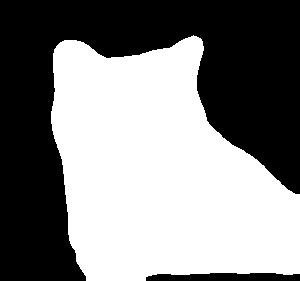

In [110]:
mask = get_mask(image)
Image.fromarray(255* np.uint8(mask == desired_category))

In [111]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

img_tensor = transforms.ToTensor()(image)

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

In [112]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   12, 12, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(my_transformer, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(my_transformer, "remote control, remote"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output
image_resized = image.resize((384, 384))
tensor_resized = transforms.ToTensor()(image_resized)


display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_vit_huggingface)))
print_top_categories(model, tensor_resized)

AttributeError: 'SegmentationModelOutputWrapper' object has no attribute 'vit'